 # 回帰2:住宅の平均価格の予測

In [191]:
import unittest
import doctest
import os

path = os.path.dirname(os.path.abspath(__file__))

 ## 住宅平均価格を予測する

 ### データの概要

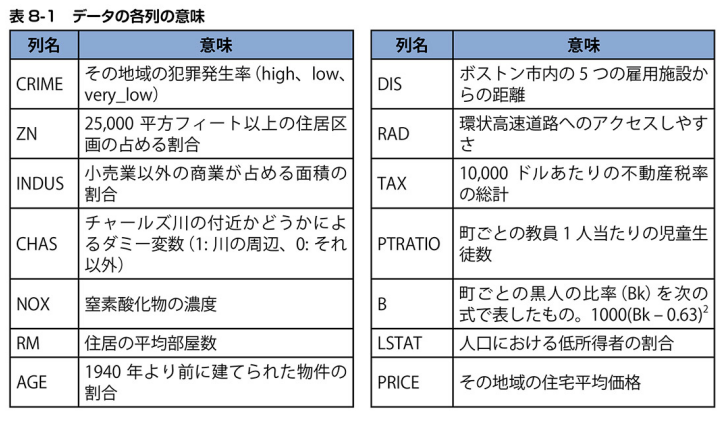

In [192]:
from PIL import Image
im = Image.open(path + '/img/8-1.png')
im

 ## データの前処理

 ### CSVファイルの読み込み

 #### ライブラリなどをインポートする

In [193]:
import pandas as pd
#%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

 #### Boston.csvを読み込む

In [194]:
df = pd.read_csv(path + '/data/Boston.csv')
df.head(2)

,CRIME,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,high,0.0,18.10,0,0.718,3.561,87.9,1.6132,24.0,666,20.2,354.7,7.12,27.5
1,low,0.0,8.14,0,0.538,5.950,82.0,3.9900,4.0,307,21.0,232.6,27.71,13.2


 ### ダミー変数化

 #### CRIME列にデータが何種類あるか調べる

In [195]:
df['CRIME'].value_counts()

very_low    50
low         25
high        25
Name: CRIME, dtype: int64

 #### ダミー変数化した列を連結しCRIME列を削除

In [196]:
crime = pd.get_dummies(df['CRIME'], drop_first=True)

df2 = pd.concat((df, crime), axis=1)
df2 = df2.drop('CRIME', axis=1)
df2.head(2)

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,low,very_low
0,0.0,18.10,0,0.718,3.561,87.9,1.6132,24.0,666,20.2,354.7,7.12,27.5,0,0
1,0.0,8.14,0,0.538,5.950,82.0,3.9900,4.0,307,21.0,232.6,27.71,13.2,1,0


 ### 訓練データ、検証データ、テストデータの分割

 #### 訓練データ&検証データとテストデータに分割する

In [197]:
train_val, test = train_test_split(df2, test_size=0.2, random_state=0)

 ### 欠損値の処理

 #### train_valの欠損値を確認する

In [198]:
train_val.isnull().sum()

ZN          0
INDUS       0
CHAS        0
NOX         1
RM          0
AGE         0
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT       0
PRICE       0
low         0
very_low    0
dtype: int64

 #### 欠損値を平均値で穴埋めする

In [199]:
train_val_mean = train_val.mean() # 各列の平均値の計算
train_val2 = train_val.fillna(train_val_mean) # 平均値で穴埋め

 ### 外れ値の処理

 #### 各特徴量の列とPRICE列の相関関係を示す散布図を描く

c:\Users\kakim\Projects\github\k2works\programing_introduce_2023\.venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


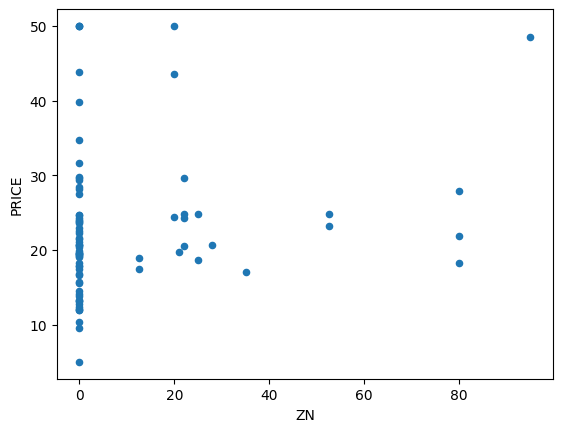

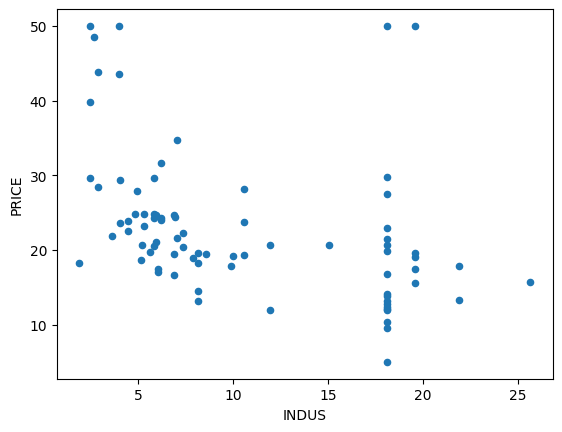

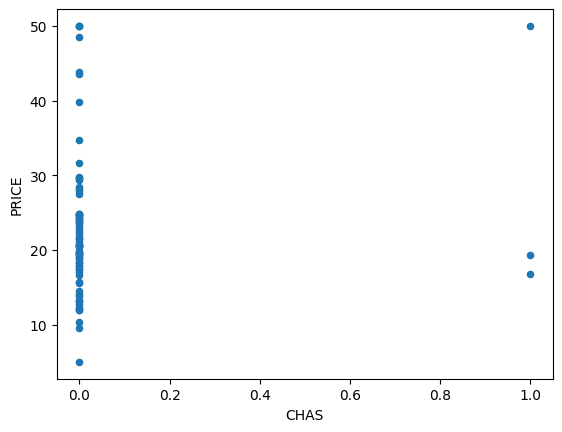

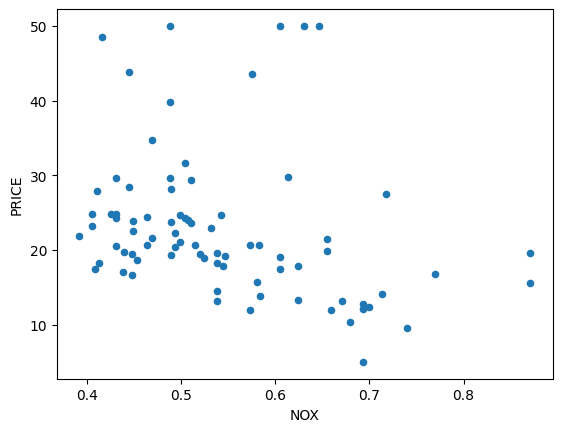

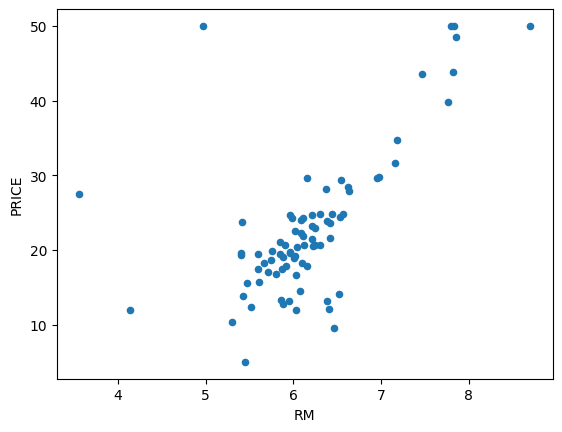

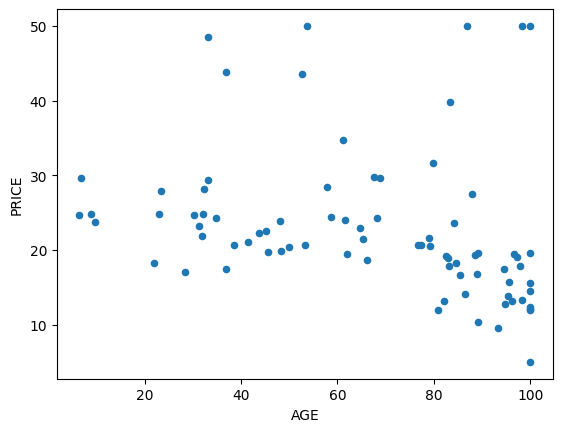

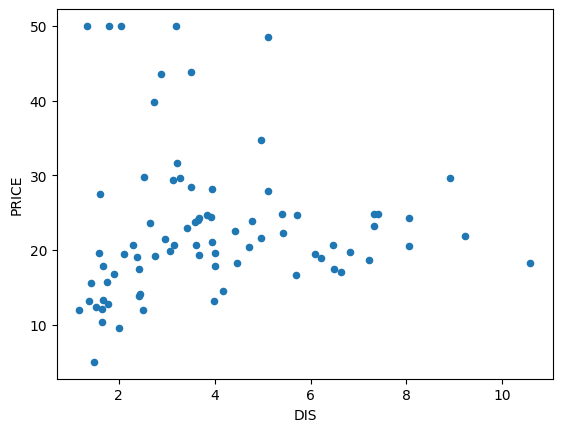

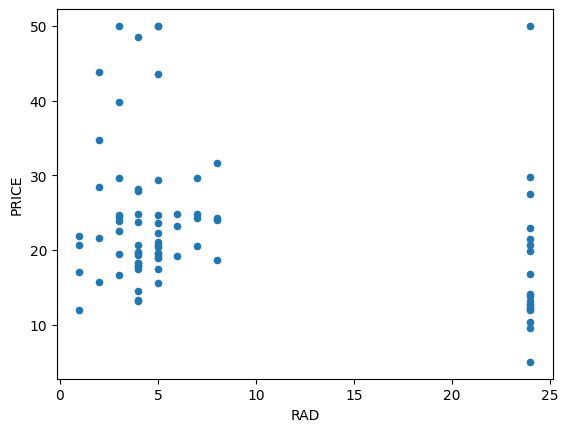

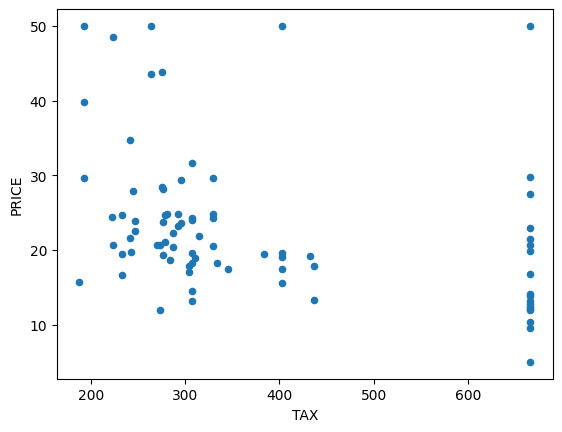

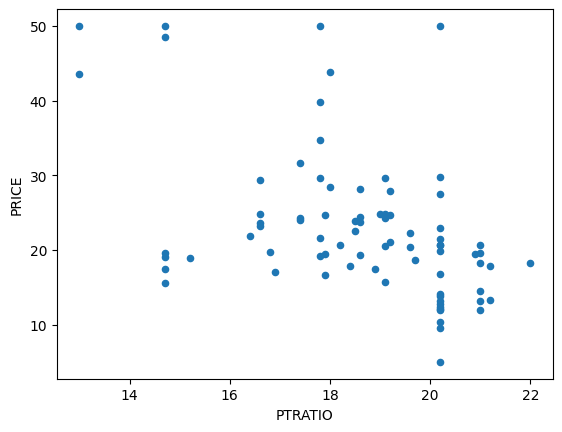

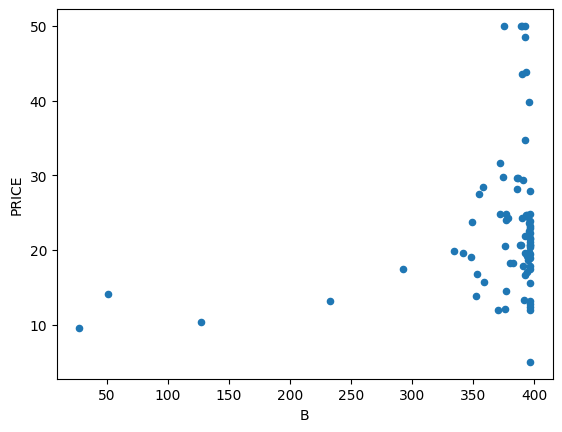

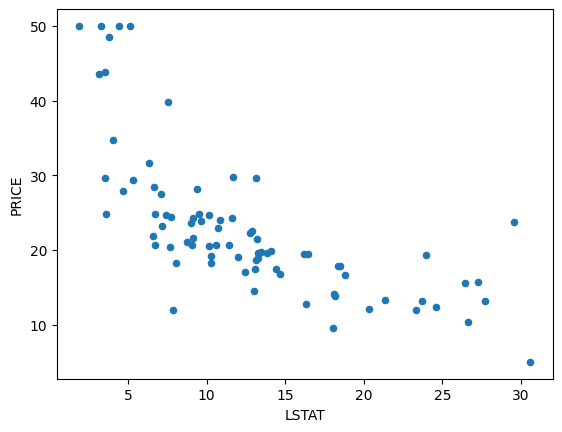

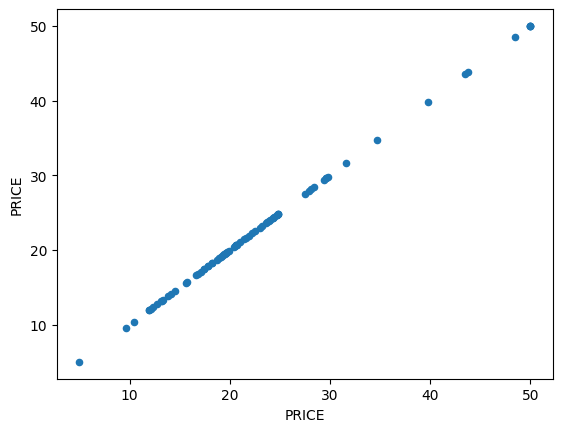

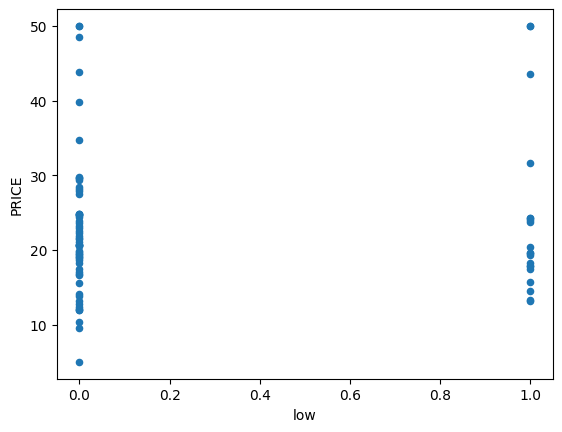

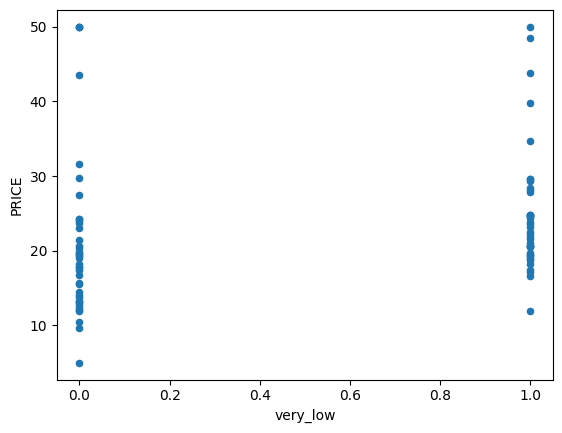

In [200]:
colname = train_val2.columns
for name in colname:
    train_val2.plot(kind='scatter', x=name, y='PRICE')

 #### 外れ値が存在するインデックスを確認する

In [201]:
# RMの外れ値
out_line1 = train_val2[(train_val2['RM'] < 6) & (train_val2['PRICE'] > 40)].index
# PTRATIOの外れ値
out_line2 = train_val2[(train_val2['PTRATIO'] > 18) & (train_val2['PRICE'] > 40)].index

print(out_line1, out_line2)

Int64Index([76], dtype='int64') Int64Index([76], dtype='int64')


 #### 外れ値を削除する

In [202]:
train_val3 = train_val2.drop([76], axis=0)

 #### 絞り込んだ列以外を取り除く

In [203]:
col = ['INDUS', 'NOX', 'RM', 'PTRATIO', 'LSTAT', 'PRICE']

train_val4 = train_val3[col]
train_val4.head(3)

,INDUS,NOX,RM,PTRATIO,LSTAT,PRICE
43,5.86,0.431,6.108,19.1,9.16,24.3
62,5.86,0.431,6.957,19.1,3.53,29.6
3,21.89,0.624,6.151,21.2,18.46,17.8


 ### 相関係数による特徴量の絞り込み

 #### 列同士の相関係数を調べる

In [204]:
train_val4.corr()

,INDUS,NOX,RM,PTRATIO,LSTAT,PRICE
INDUS,1.000000,0.785722,-0.403129,0.249438,0.578406,-0.470889
NOX,0.785722,1.000000,-0.272996,0.077533,0.484295,-0.325289
RM,-0.403129,-0.272996,1.000000,-0.404568,-0.560454,0.753771
PTRATIO,0.249438,0.077533,-0.404568,1.000000,0.326563,-0.542449
LSTAT,0.578406,0.484295,-0.560454,0.326563,1.000000,-0.693490
PRICE,-0.470889,-0.325289,0.753771,-0.542449,-0.693490,1.000000


 #### 各列とPRICE列との相関係数を見る

In [205]:
train_cor = train_val4.corr()['PRICE']
train_cor

INDUS     -0.470889
NOX       -0.325289
RM         0.753771
PTRATIO   -0.542449
LSTAT     -0.693490
PRICE      1.000000
Name: PRICE, dtype: float64

 #### abs関数で絶対値に変換

In [206]:
print(abs(1)) # 1の絶対値を計算
print(abs(-2)) # -2の絶対値を計算

1
2


 #### mapメソッドで要素に関数を適用する

In [207]:
se = pd.Series([1, 2, 3, 4, 5]) # シリーズの作成

# seの各要素にabs関数を適応させた結果をシリーズ化
se.map(abs)

0    1
1    2
2    3
3    4
4    5
dtype: int64

 #### 相関行列のPRICE列との相関係数を絶対値に変換する

In [208]:
abs_cor = train_cor.map(abs)
abs_cor

INDUS      0.470889
NOX        0.325289
RM         0.753771
PTRATIO    0.542449
LSTAT      0.693490
PRICE      1.000000
Name: PRICE, dtype: float64

 #### sort_valuesメソッドで要素を降順に並び替える

In [209]:
# 降順に並べ替える
abs_cor.sort_values(ascending=False)

PRICE      1.000000
RM         0.753771
LSTAT      0.693490
PTRATIO    0.542449
INDUS      0.470889
NOX        0.325289
Name: PRICE, dtype: float64

 ### 訓練データと検証データの分割

 #### 訓練データと検証データに分割する

In [210]:
col = ['RM', 'LSTAT', 'PTRATIO']
x = train_val4[col]
t = train_val4[['PRICE']]

# 訓練データと検証データに分割する
x_train, x_val, y_train, y_val = train_test_split(x, t, test_size=0.2, random_state=0)

 ### データの標準化

 #### scikit-learnのpreprocessingモジュールを使う

In [211]:
from sklearn.preprocessing import StandardScaler

sc_model_x = StandardScaler()
sc_model_x.fit(x_train)

# 各列のデータを標準化してsc_xに代入
sc_x = sc_model_x.transform(x_train)
sc_x # 表示

array([[-0.10238334, -0.89546338, -0.97250163],
       [-0.11741281, -0.37386886,  1.21732721],
       [-0.92274224,  2.49984836,  0.83648742],
       [ 1.60346221, -1.37747891, -2.59107078],
       [-0.21134704, -0.36821472, -0.30603198],
       [ 0.28337322, -0.54632017, -0.87729168],
       [ 2.01927772, -1.55275729, -1.7817862 ],
       [-0.42551707, -0.58448562,  0.36043767],
       [-0.39420567,  0.21557535, -1.7817862 ],
       [-0.21886178, -0.00634969,  0.02720284],
       [-0.48438252,  0.24525959,  0.83648742],
       [ 0.02411475,  0.04453758,  0.83648742],
       [ 0.31092726, -1.31669689,  0.31283269],
       [ 2.08315299, -1.28559912, -1.7817862 ],
       [-0.98411261,  1.56550154,  0.07480782],
       [-0.28398951,  0.07704889, -0.78208173],
       [-0.9039554 ,  1.91040415, -1.7817862 ],
       [ 0.23828479,  1.52450902,  0.83648742],
       [-0.12993738, -0.28622968, -0.49645188],
       [-0.18629791, -0.73573389,  0.55085757],
       [-0.37917619,  0.48697412,  0.836

 #### 平均値0を確認する

In [212]:
# array型だと見づらいのでデータフレームに変換
tmp_df = pd.DataFrame(sc_x, columns=x_train.columns)
# 平均値の計算
tmp_df.mean()

RM        -3.418782e-16
LSTAT      1.445052e-16
PTRATIO   -1.436241e-16
dtype: float64

 #### 標準偏差1を確認する

In [213]:
tmp_df.std() # 標準偏差の計算

RM         1.008032
LSTAT      1.008032
PTRATIO    1.008032
dtype: float64

 #### 正解データを標準化する

In [214]:
sc_model_y = StandardScaler()
sc_model_y.fit(y_train)

sc_y = sc_model_y.transform(y_train)

 ## モデルの作成と学習

 #### 標準化したデータで学習させる

In [215]:
model = LinearRegression()
model.fit(sc_x, sc_y) # 標準化済みの訓練データで学習

LinearRegression()

 ## モデルの評価とチューニング

 ### 標準化データによる予測性能の評価

 #### scoreメソッドで決定係数を求める

In [216]:
model.score(x_val, y_val)

c:\Users\kakim\Projects\github\k2works\programing_introduce_2023\.venv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


-13.085044375040098

 #### 検証データを標準化する

In [217]:
sc_x_val = sc_model_x.transform(x_val)
sc_y_val = sc_model_y.transform(y_val)
# 標準化した検証データで決定係数を計算
model.score(sc_x_val, sc_y_val)

0.7359028880291

 #### 間違って検証データの平均値と標準偏差を使って標準化

In [218]:
# 以下、やってはいけない間違いコード
sc_model_x2 = StandardScaler()
sc_model_x2.fit(x_val)
sc_x_val = sc_model_x2.transform(x_val)
sc_model_y2 = StandardScaler()
sc_model_y2.fit(y_val)
sc_y_val = sc_model_y2.transform(y_val)
model.score(sc_x_val, sc_y_val)

0.791811786357224

 ### チューニングの目標と準備

 #### learn関数の定義

In [219]:
def learn(x,t):
    x_train, x_val, y_train, y_val = train_test_split(x, t, test_size=0.2, random_state=0)
    # 訓練データを標準化
    sc_model_x = StandardScaler()
    sc_model_y = StandardScaler()
    sc_model_x.fit(x_train)
    sc_x_train = sc_model_x.transform(x_train)
    sc_model_y.fit(y_train)
    sc_y_train = sc_model_y.transform(y_train)
    # 学習
    model = LinearRegression()
    model.fit(sc_x_train, sc_y_train)

    # 検証データを標準化
    sc_x_val = sc_model_x.transform(x_val)
    sc_y_val = sc_model_y.transform(y_val)
    # 訓練データと検証データの決定係数計算
    train_score = model.score(sc_x_train, sc_y_train)
    val_score = model.score(sc_x_val, sc_y_val)

    return train_score, val_score

 #### learn関数を実行する

In [220]:
x = train_val3.loc[:, ['RM', 'LSTAT', 'PTRATIO']]
t = train_val3[['PRICE']]

s1,s2 = learn(x,t)
print(s1, s2)

0.7175897572515981 0.7359028880291


 ### 特徴量の追加

 #### 特徴量にINDUS列を追加する

In [221]:
x = train_val3.loc[:, ['RM', 'LSTAT', 'PTRATIO', 'INDUS']]
t = train_val3[['PRICE']]
s1,s2 = learn(x,t)
print(s1, s2)

0.7190252930186809 0.7295535344941491


 ### 特徴量エンジニアリング

 ### 多項式特徴量と多項式回帰

 #### データフレームのRM列のデータを2乗する

In [222]:
x['RM'] ** 2

43    37.307664
62    48.399849
3     37.834801
71    37.307664
45    35.557369
        ...    
96    33.166081
67    39.816100
64    39.050001
47    43.890625
44    34.222500
Name: RM, Length: 79, dtype: float64

 #### 新しい列を特徴量に追加する

In [223]:
# RM2乗のシリーズを新しい列として追加
x['RM2'] = x['RM'] ** 2
# コード8-29で、INDUS列を追加したので削除
x = x.drop('INDUS', axis=1)
x.head(2)

,RM,LSTAT,PTRATIO,RM2
43,6.108,9.16,19.1,37.307664
62,6.957,3.53,19.1,48.399849


 #### 行を追加する

In [224]:
# インデックスを2000として新しい行を追加
x.loc[2000] = [10,7,8,100]
print(x.tail(2)) # 確認

# 第8章の本筋に関係ないので削除
x = x.drop(2000, axis=0)

         RM  LSTAT  PTRATIO       RM2
44     5.85   8.77     19.2   34.2225
2000  10.00   7.00      8.0  100.0000


 #### 新しい列が追加されたので再学習を行う

In [225]:
s1,s2 = learn(x,t)
print(s1, s2)

0.8456207631185566 0.8372526287986779


 #### LSTAT列とPTRATIO列で新しい列を特徴量に追加する

In [226]:
# LSTAT列の2乗を追加
x['LSTAT2'] = x['LSTAT'] ** 2
s1,s2 = learn(x,t)
print(s1, s2)

# PTRATIO列の2乗を追加
x['PTRATIO2'] = x['PTRATIO'] ** 2
s1,s2 = learn(x,t)
print(s1, s2)

0.8565689444345093 0.8425282632102129
0.864383498898444 0.8678022326740726


 ### 交互作用特徴量

 #### 2つのシリーズに算術演算を行う

In [227]:
se1 = pd.Series([1,2,3])
se2 = pd.Series([10,20,30])
se1 + se2 # 対応する各要素を足し算したシリーズ

0    11
1    22
2    33
dtype: int64

 #### 交互作用特徴量を追加する

In [228]:
x['RM * LSTAT'] = x['RM'] * x['LSTAT']
x.head(2)

,RM,LSTAT,PTRATIO,RM2,LSTAT2,PTRATIO2,RM * LSTAT
43,6.108,9.16,19.1,37.307664,83.9056,364.81,55.94928
62,6.957,3.53,19.1,48.399849,12.4609,364.81,24.55821


 #### 交互作用特徴量を追加したので再学習を行う

In [229]:
s1,s2 = learn(x,t)
print(s1, s2)

0.8668534967796697 0.8739347357775972


 #### データの標準化後に再学習を行う

In [230]:
# 訓練データと検証データを合わせて再学習させるので
# 再度、標準化する
sc_model_x2 = StandardScaler()
sc_model_x2.fit(x)
sc_x = sc_model_x2.transform(x)

sc_model_y2 = StandardScaler()
sc_model_y2.fit(t)
sc_y = sc_model_y2.transform(t)
model = LinearRegression()
model.fit(sc_x, sc_y)

LinearRegression()

 ### テストデータでの評価

 #### テストデータの前処理

In [231]:
test2 = test.fillna(train_val.mean()) # 欠損値を平均値で補完
x_test = test2.loc[:, ['RM', 'LSTAT', 'PTRATIO']]
y_test = test2[['PRICE']]

x_test['RM2'] = x_test['RM'] ** 2
x_test['LSTAT2'] = x_test['LSTAT'] ** 2
x_test['PTRATIO2'] = x_test['PTRATIO'] ** 2

x_test['RM * LSTAT'] = x_test['RM'] * x_test['LSTAT']

sc_x_test = sc_model_x2.transform(x_test)
sc_y_test = sc_model_y2.transform(y_test)

 #### 決定係数を計算する

In [232]:
model.score(sc_x_test, sc_y_test)

0.7649249353669053

 ### モデルの保存

 #### モデルを保存する

In [233]:
import pickle
with open(path + '/data/boston.pkl', mode='wb') as fp:
    pickle.dump(model, fp)
with open(path + '/data/boston_scx.pkl', mode='wb') as fp:
    pickle.dump(sc_model_x2, fp)
with open(path + '/data/boston_scy.pkl', mode='wb') as fp:
    pickle.dump(sc_model_y2, fp)

In [234]:
doctest.testmod(verbose=True)
unittest.main(argv=[''], verbosity=2, exit=False)

4 items had no tests:
    __main__
    __main__.__VSCODE_compute_hash
    __main__.__VSCODE_wrap_run_cell
    __main__.learn
0 tests in 4 items.
0 passed and 0 failed.
Test passed.



----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK
